#### Modelo Termodinâmico

Adsorção de microplásticos baseado no modelo de Ising 2D

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib import font_manager

font_path = '../Ruda/Ruda-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [3]:
# Extração da média de cargas: Coulomb e LJ
# B1 - PS

avogrado = 6.02e22

print('B1-PS')
print(round(2.7331632e+22/avogrado,4),'eV - Coulomb')
print(round(-4.0678101e23/avogrado,4),'eV - LJ')

print('\nCBM-Spid')
print(round(-2.449006e+24/avogrado,4),'eV - Coulomb')
print(round(-7.0256926e+23/avogrado,4),'eV - LJ')

print('\nSpid-PS')
print(round(2.95235251e+23/avogrado,4),'eV - Coulomb')
print(round(-5.1449448e+22/avogrado,4),'eV - LJ')

print('\nB1-B1')
print(round(4.9752819e+22/avogrado,4),'ev - Coulomb')
print(round(2.3915154e+23/avogrado,4),'ev - LJ')

print('\nSpid-Spid')
print(round(1.1105705e+24/avogrado,4),'ev - Coulomb')
print(round(4.70770211e+24/avogrado,4),'ev - LJ')

print('\nPS-PS')
# print(round(
# print(round(

B1-PS
0.454 eV - Coulomb
-6.7572 eV - LJ

CBM-Spid
-40.6812 eV - Coulomb
-11.6706 eV - LJ

Spid-PS
4.9042 eV - Coulomb
-0.8546 eV - LJ

B1-B1
0.8265 ev - Coulomb
3.9726 ev - LJ

Spid-Spid
18.448 ev - Coulomb
78.201 ev - LJ

PS-PS


In [4]:
# Extraidos dinamica
E_CBMP = 0.045   # Energia CBM-MP : 0.045 eV
E_CBMS = - 40.7   # Energia CBM-Espid
E_SMP = 4.9    # Energia Espid-MP
E_CBMCBM = 0.8  # Energia CBM-CBM
E_SS = 18.448      # Energia Espid-Espid

# Aleatorios
# E_CBMP = 0.5   # Energia CBM-MP : 0.045 eV
# E_CBMS = - 0.1   # Energia CBM-Espid
# E_SMP = 0.2    # Energia Espid-MP
# E_CBMCBM = 0.2  # Energia CBM-CBM
# E_SS = 0.2      # Energia Espid-Espid

E_MPMP = 0.1    # Energia MP-MP

In [5]:
def calcular_energia(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP):
    energia = 0
    tamanho = len(rede)
    for i in range(tamanho):
        for j in range(tamanho):
            S = rede[i, j]
            if S == 0:
                continue

            # Interacao Vizinhos
            vizinhos = [
                rede[(i+1) % tamanho, j],
                rede[i, (j+1) % tamanho],
                rede[(i-1) % tamanho, j],
                rede[i, (j-1) % tamanho]
            ]
            
            for V in vizinhos:
                if S == 1:  # CBM
                    if V == -1:  # CBM com MP
                        energia += E_CBMP
                    elif V == 2:  # CBM com espid
                        energia += E_CBMS
                    elif V == 1:  # CBM com CBM
                        energia += E_CBMCBM
                elif S == 2:  # Espid
                    if V == -1:  # Espid com MP
                        energia += E_SMP
                    elif V == 2:  # Espid com espid
                        energia += E_SS
                elif S == -1:  # MP
                    if V == -1:  # MP com MP
                        energia += E_MPMP

    return energia

def monte_carlo(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP, T, passos):
    tamanho = len(rede)
    for passo in range(passos):
        
        # Posicao aleatoria na rede
        i = np.random.randint(0, tamanho)
        j = np.random.randint(0, tamanho)
        S = rede[i, j]
        
        # Proteinas CBM e espid não mudam de posicao, ignoramos
        if S == 1 or S == 2:
            continue
        
        # Calcular a energia atual e a energia se mudar o estado
        energia_antiga = calcular_energia(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP)
        novo_estado = np.random.choice([-1, 0])  # Tenta alterar o estado para MP ou vazio
        rede[i, j] = novo_estado
        energia_nova = calcular_energia(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP)
        
        # Decisao de aceitar ou nao a mudanca
        delta_energia = energia_nova - energia_antiga
        if delta_energia > 0 and np.random.rand() >= np.exp(-delta_energia / T):
            rede[i, j] = S  # Reverter se nao aceitar
        
    return rede

# Funcao para calcular a eficiencia do sistema
def calcular_eficiencia(energias):
    energia_inicial = energias[0]
    energia_final = energias[-1]
    eficiencia = (energia_inicial - energia_final) / abs(energia_inicial)
    return eficiencia

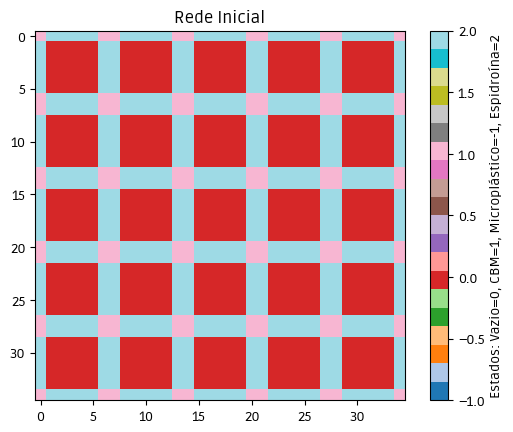

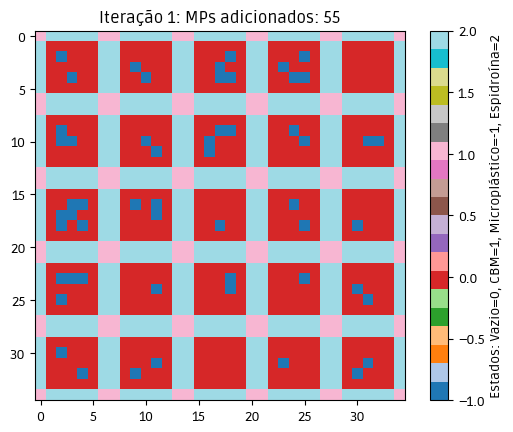

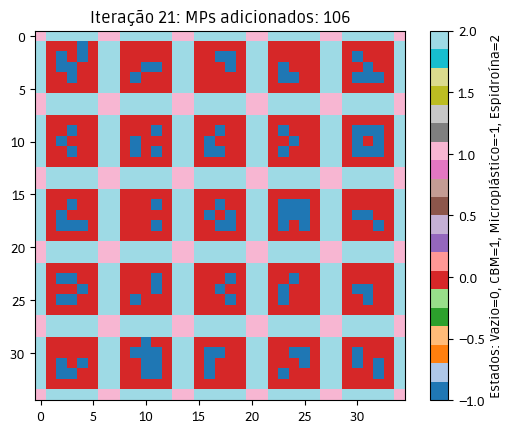

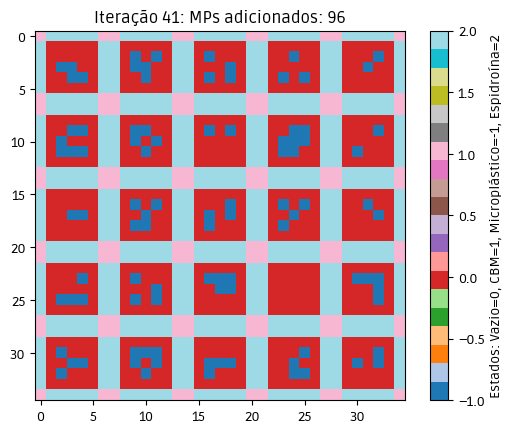

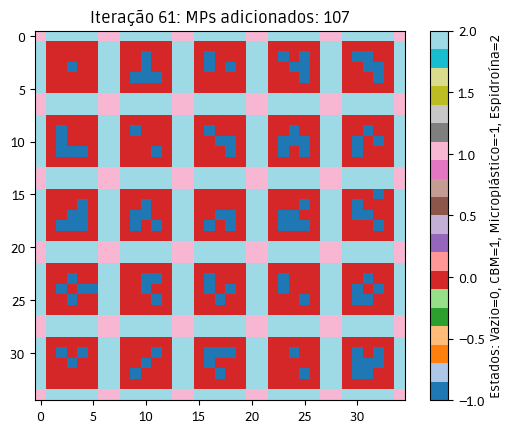

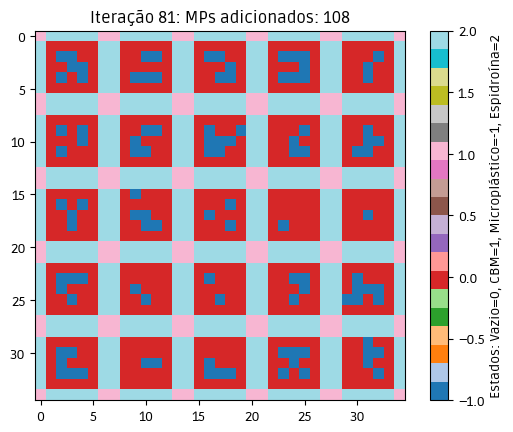

In [8]:
# Parametros do modelo
tamanho_rede = 35 # rede quadrática
T = 1.0  # temperatura
passos = 1000  # número de passos de Monte Carlo por adição de microplástico

# Padrao 7x7 que sera repetido
padrao = np.array([
    [1, 2, 2, 2, 2, 2, 1],
    [2, 0, 0, 0, 0, 0, 2],
    [2, 0, 0, 0, 0, 0, 2],
    [2, 0, 0, 0, 0, 0, 2],
    [2, 0, 0, 0, 0, 0, 2],
    [2, 0, 0, 0, 0, 0, 2],
    [1, 2, 2, 2, 2, 2, 1],
])

rede = np.tile(padrao, (tamanho_rede // 7, tamanho_rede // 7))

it = 100 # iteracoes

mps,energias = [0],[]

energia_inicial = calcular_energia(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP)
energias.append(energia_inicial)

plt.imshow(rede, cmap='tab20', vmin=-1, vmax=2)
plt.title('Rede Inicial')
plt.colorbar(label='Estados: Vazio=0, CBM=1, Microplástico=-1, Espidroína=2')
plt.show()

for n in range(it):

    rede = monte_carlo(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP, T, passos)

    energia_atual = calcular_energia(rede, E_CBMP, E_CBMS, E_SMP, E_CBMCBM, E_SS, E_MPMP)
    energias.append(energia_atual)
    
    mps_add = list(rede.flatten()).count(-1)
    mps.append(mps_add)
    
    if n % 20 == 0:
    # if False:
        plt.imshow(rede, cmap='tab20', vmin=-1, vmax=2)
        plt.title(f'Iteração {n+1}: MPs adicionados: {mps_add}')
        plt.colorbar(label='Estados: Vazio=0, CBM=1, Microplástico=-1, Espidroína=2')
        plt.pause(0.5)

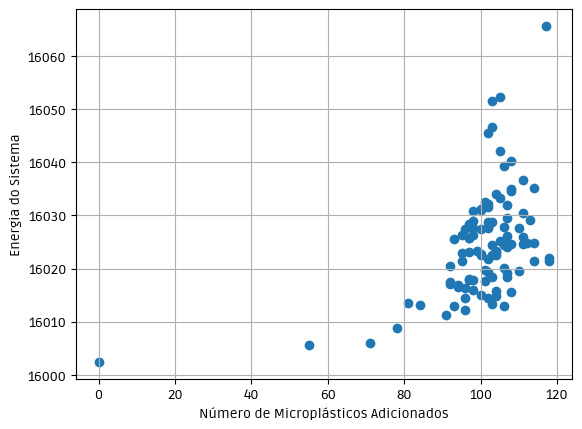

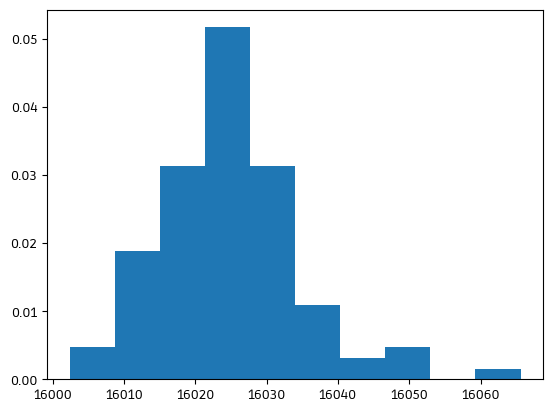

Eficiência do sistema: -0.00


In [13]:
plt.figure()
plt.scatter(mps, energias)

plt.grid()

plt.xlabel('Número de Microplásticos Adicionados')
plt.ylabel('Energia do Sistema')

plt.show()

plt.hist(energias,density=True);plt.show()

eficiencia = calcular_eficiencia(energias)
print(f'Eficiência do sistema: {eficiencia:.2f}')

Próximos passos:

- Quantos MPs podem ser capturados por poro?
- Dada a quantidade de MPs que podem ser capturados por poro, quantos poros seriam necessários para filtrar 1L de água?

Com base na quantidade média de partículas, determinar tamanho da rede - determina viabilidade

Modelagem permite definir a [CBM] que seria necessária para filtrar de uma forma eficiente

Purificação é caro, threshold arbitrário

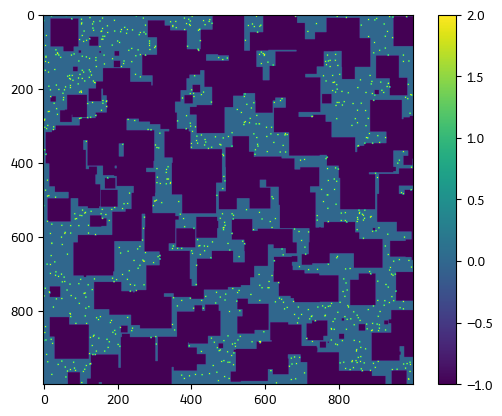

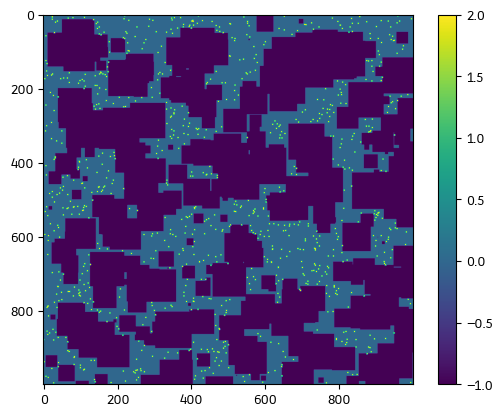

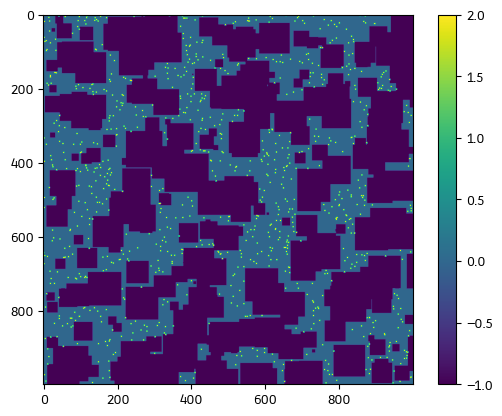

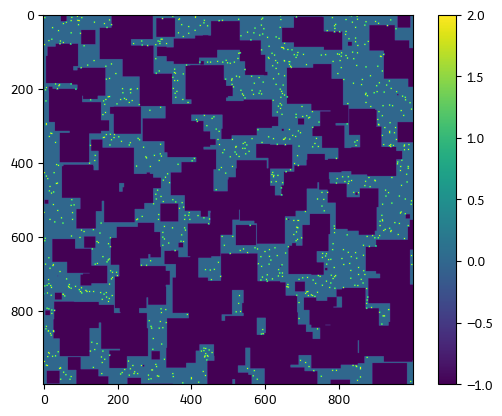

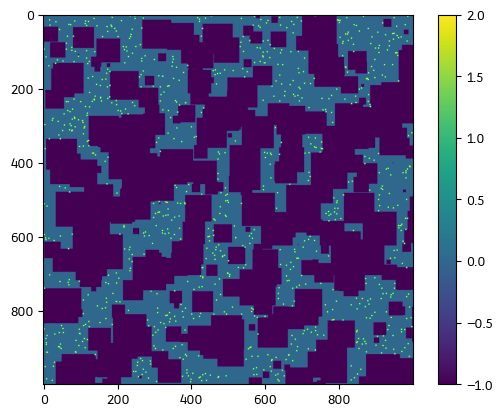

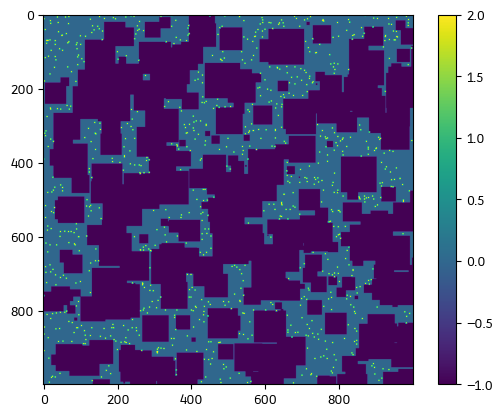

In [463]:
tamanho_rede = 1000
porosidade = 0.3
camadas = 6
limite_tamanho_poro = 100
concentracao_cbm = 0.9
tamanho_cbm = 4

filtro = []

# gerar camadas - sistema tridimensional

for camada in range(camadas):

    # gerar rede

    rede = np.zeros([tamanho_rede,tamanho_rede])

    # definir porosidade

    poros = round(porosidade * tamanho_rede)

    for poro in range(poros):

        # 2 alternativas:
        # 1. gerar tamanho aleatório do poro | colocar os poros na rede
        
        tamanho_poro = np.random.randint(1,limite_tamanho_poro)
        posicao_poro_x,posicao_poro_y = np.random.randint(tamanho_rede),np.random.randint(tamanho_rede)

        for i in range(tamanho_poro):
            for j in range(tamanho_poro):
                
                if posicao_poro_x+i < tamanho_rede and posicao_poro_y+j < tamanho_rede:
                    rede[posicao_poro_x+i,posicao_poro_y+j] = -1

        # 2. quantidade de cadeias que vamos colocar

    # insercao das proteínas CBM

    proteinas = round(concentracao_cbm * tamanho_rede)

    for proteina in range(proteinas):
        
        condicao = True

        while condicao:

            posicao_prot_x,posicao_prot_y = np.random.randint(tamanho_rede),np.random.randint(tamanho_rede)

            if rede[posicao_prot_x,posicao_prot_y] != -1 and posicao_prot_x+tamanho_cbm < tamanho_rede and posicao_prot_y+tamanho_cbm < tamanho_rede:

                rede[posicao_prot_x:posicao_prot_x+tamanho_cbm,posicao_prot_y:posicao_prot_y+tamanho_cbm] = 2
                condicao = False

    # exibir rede

    if True:
        plt.imshow(rede,vmin=-1,vmax=2)
        plt.colorbar()
        plt.show()

    filtro.append(rede)

In [464]:
qnt_mps = 1000
tamanho_limite_mp = 20
mps_dic = {}

# gerar microplasticos

for mp in range(qnt_mps):

    while True:

        tamanho_mp = np.random.randint(1,tamanho_limite_mp)
        posicao_mp_x,posicao_mp_y = np.random.randint(tamanho_rede),np.random.randint(tamanho_rede)

        while posicao_mp_x+tamanho_mp > tamanho_rede or posicao_mp_y+tamanho_mp > tamanho_rede:
            posicao_mp_x,posicao_mp_y = np.random.randint(tamanho_rede),np.random.randint(tamanho_rede)

        # restricao para posicionamento do mp
        # por exemplo, dois microplasticos nao podem ocupar o mesmo espaco

        if len(mps_dic) == 0: break

        for mp_k,mp_v in mps_dic.items():
            
            tamanho_mp_comp,posicao_mp_comp = mp_v

            #calculando o overlap de dois microplasticos como quadrados

            x1_min, x1_max = posicao_mp_x, posicao_mp_x + tamanho_mp
            y1_min, y1_max = posicao_mp_y, posicao_mp_y + tamanho_mp
            
            x2_min, x2_max = posicao_mp_comp[0], posicao_mp_comp[0] + tamanho_mp_comp
            y2_min, y2_max = posicao_mp_comp[1], posicao_mp_comp[1] + tamanho_mp_comp
            
            overlap_x = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
            
            overlap_y = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
            
            overlap_area = overlap_x * overlap_y

            if overlap_area > 0: break
        
        if overlap_area == 0: break

    mps_dic.update({mp:[tamanho_mp,[posicao_mp_x,posicao_mp_y]]})

    # rede[posicao_mp_x:posicao_mp_x+tamanho_mp,posicao_mp_y:posicao_mp_y+tamanho_mp]

In [465]:
b1_ps = 0.454
spid_ps = 4.9042

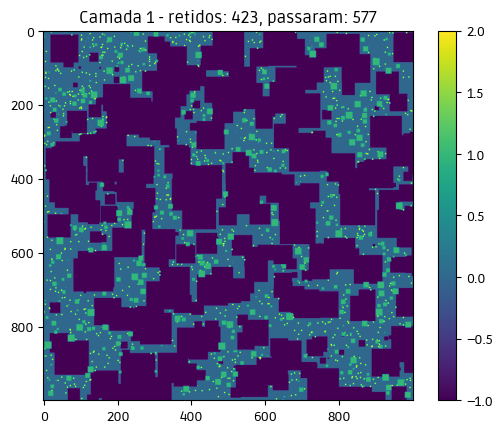

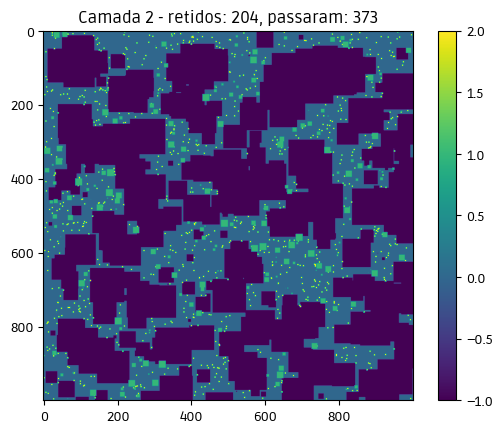

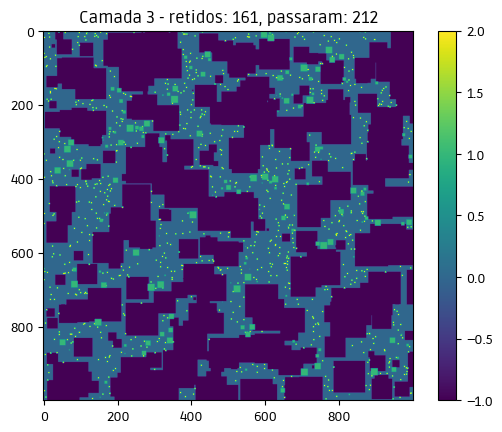

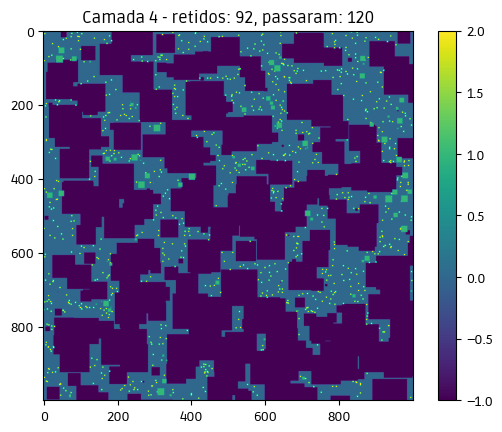

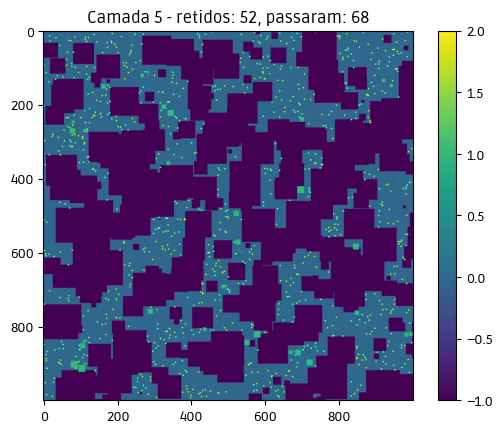

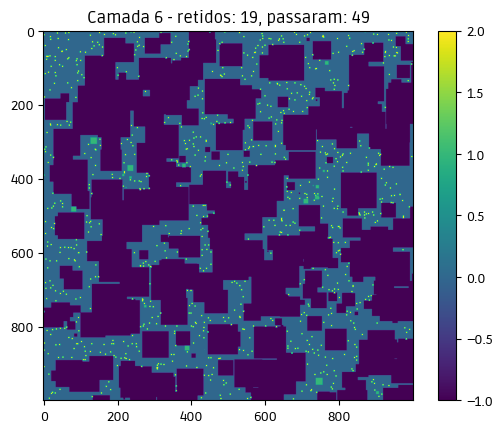

In [466]:
mps_retidos,retencao_camada = 0,[]

for i,rede in enumerate(filtro):
    
    mps_retidos_camada = 0

    for mp_k in list(mps_dic.keys()):

        mp_tamanho,mp_posicao = mps_dic[mp_k]
        
        # se o mp estiver em cima de cbm, calcular overlap
        # se nao, P = 0

        regiao_overlap = rede[mp_posicao[0]:mp_posicao[0]+mp_tamanho,mp_posicao[1]:mp_posicao[1]+mp_tamanho]
        regiao_overlap_vizinhos = rede[mp_posicao[0]:mp_posicao[0]+mp_tamanho,mp_posicao[1]:mp_posicao[1]+mp_tamanho]

        regiao_overlap = regiao_overlap.flatten()

        # fibra = -1 | vazio = 0 | cbm = 2

        fibra_count = list(regiao_overlap).count(0)
        vazio_count = list(regiao_overlap).count(-1)
        cbm_count = list(regiao_overlap).count(2)

        # calculo da propriedade por meio da energia de interacao e distancia
        # considerar energia on-site + 1os vizinhos
        
        # B1-PS # 0.454 eV - Coulomb # -6.7572 eV - LJ
        # CBM-Spid # -40.6812 eV - Coulomb # -11.6706 eV - LJ
        # Spid-PS # 4.9042 eV - Coulomb # -0.8546 eV - LJ

        energia = fibra_count*spid_ps + cbm_count*b1_ps

        # calculo da probabilidade, depende de
            # overlap fibra
            # overlap cbm
            # overlap buracos

        p_reter = ((fibra_count+cbm_count) - vazio_count)/mp_tamanho

        if p_reter > np.random.random():
            
            rede[mp_posicao[0]:mp_posicao[0]+mp_tamanho,mp_posicao[1]:mp_posicao[1]+mp_tamanho] = 1
            mps_retidos += 1
            mps_retidos_camada += 1
            del mps_dic[mp_k]

    retencao_camada.append(mps_retidos_camada)
    plt.imshow(rede,vmin=-1,vmax=2)
    plt.title(f'Camada {i+1} - retidos: {mps_retidos_camada}, passaram: {len(mps_dic)}')
    plt.colorbar()
    plt.show()

Qtd total MPs 1000, qtd MPs retidos 951
Eficiência: 95.0%


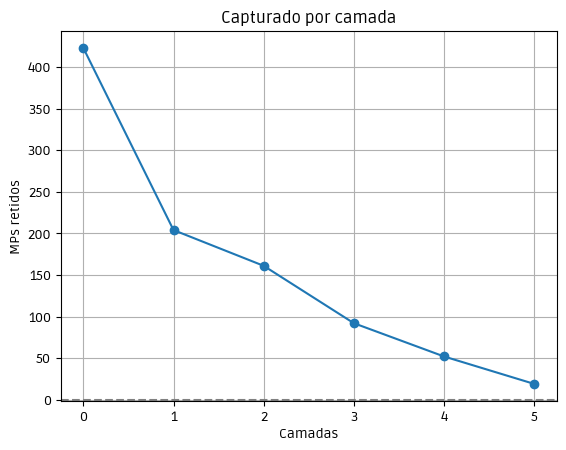

In [467]:
print(f'Qtd total MPs {qnt_mps}, qtd MPs retidos {mps_retidos}')
print(f'Eficiência: {100*(round(mps_retidos/qnt_mps,2))}%')

plt.plot(range(camadas),retencao_camada,'-o')
plt.title('Capturado por camada')

plt.xlabel('Camadas')
plt.ylabel('MPs retidos')

plt.axhline(y=0,color='gray',linestyle='--')

plt.grid()
plt.show()